<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#First-look-at-data" data-toc-modified-id="First-look-at-data-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>First look at data</a></span></li><li><span><a href="#Numerical-features-EDA" data-toc-modified-id="Numerical-features-EDA-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Numerical features EDA</a></span></li><li><span><a href="#Non-Numerical-features-EDA" data-toc-modified-id="Non-Numerical-features-EDA-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Non Numerical features EDA</a></span></li><li><span><a href="#Target-EDA" data-toc-modified-id="Target-EDA-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Target EDA</a></span></li><li><span><a href="#A-little-preprocessing" data-toc-modified-id="A-little-preprocessing-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>A little preprocessing</a></span></li><li><span><a href="#Random-Forest" data-toc-modified-id="Random-Forest-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Random Forest</a></span></li><li><span><a href="#Evaluation" data-toc-modified-id="Evaluation-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Evaluation</a></span></li></ul></div>

In [189]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, GridSearchCV

%matplotlib inline

In [195]:
path = '/Users/MacBookProCasa/Documents/Formación/Data_science/Python/Projects/Gudog/price_prediction/walking_es'
data = pd.read_csv(path + '/walking_es.csv')

## First look at data

First I look at the shape of the dataset I am going to work with, and I show the data type of each feature

In [196]:
original_shape = data.shape
print('Columns {} \nRows {}'.format(original_shape[0], original_shape[1]))

Columns 4913 
Rows 23


Because the dataset contains sensitive information, I will anonymize the dataset. The feature I want to predict is the price of the service which we will leave as target.

In [197]:
for i, feature in enumerate(data.columns):
    if feature == 'price_cents':
        data.rename(columns={'price_cents': 'target'}, inplace=True)
    else:
        data.rename(columns={feature: 'feat' + str(i)}, inplace=True)
    
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4913 entries, 0 to 4912
Data columns (total 23 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   feat0   4913 non-null   int64  
 1   feat1   4433 non-null   float64
 2   feat2   4913 non-null   int64  
 3   feat3   1901 non-null   float64
 4   feat4   4913 non-null   int64  
 5   feat5   4913 non-null   bool   
 6   feat6   4913 non-null   bool   
 7   feat7   4913 non-null   bool   
 8   feat8   4913 non-null   bool   
 9   feat9   4913 non-null   bool   
 10  feat10  4913 non-null   bool   
 11  feat11  4913 non-null   bool   
 12  feat12  4913 non-null   bool   
 13  feat13  2590 non-null   object 
 14  feat14  2590 non-null   object 
 15  feat15  2590 non-null   object 
 16  feat16  4913 non-null   int64  
 17  target  4913 non-null   int64  
 18  feat18  4913 non-null   bool   
 19  feat19  0 non-null      float64
 20  feat20  4361 non-null   float64
 21  feat21  4913 non-null   object 
 22  

## Numerical features EDA

First I will explore the numerical features. With the describe() function for each feature I check the number of non-null values, the mean and variance, the minimum and maximum values and the 25%, 50% and 75% quartiles.

Then I will check which features have null values.

In [198]:
data.describe()

,feat0,feat1,feat2,feat3,feat4,feat16,target,feat19,feat20,feat22
count,4913.000000,4433.000000,4913.000000,1901.000000,4913.000000,4913.000000,4913.000000,0.0,4361.000000,4913.000000
mean,332600.557297,24826.479134,2972.115205,4.974997,2.663342,0.540199,9.249338,NaN,5.709012,6.363729
std,156871.416582,13250.655792,1905.944842,0.156239,7.974833,0.766022,2.577921,NaN,3.911572,25.035256
min,33.000000,1001.000000,1006.000000,2.000000,0.000000,0.000000,6.000000,NaN,0.000000,0.000000
25%,217403.000000,8911.000000,2280.000000,5.000000,0.000000,0.000000,7.000000,NaN,0.000000,0.000000
50%,348972.000000,28001.000000,2430.000000,5.000000,0.000000,0.000000,9.000000,NaN,6.000000,0.000000
75%,484610.000000,29730.000000,3190.000000,5.000000,2.000000,1.000000,10.000000,NaN,10.000000,4.000000
max,550546.000000,52001.000000,31905.000000,5.000000,147.000000,6.000000,34.000000,NaN,10.000000,992.000000


In [199]:
numerical_feat = data.select_dtypes(['int64', 'float64'])
numerical_feat.isnull().sum()

feat0        0
feat1      480
feat2        0
feat3     3012
feat4        0
feat16       0
target       0
feat19    4913
feat20     552
feat22       0
dtype: int64

In [200]:
numerical_feat.loc[:,numerical_feat.isna().any()]

,feat1,feat3,feat19,feat20
0,15001.0,5.0,NaN,10.0
1,20160.0,5.0,NaN,0.0
2,28001.0,5.0,NaN,0.0
3,28001.0,5.0,NaN,0.0
4,28850.0,5.0,NaN,0.0
...,...,...,...,...
4908,8001.0,NaN,NaN,10.0
4909,28001.0,NaN,NaN,10.0
4910,21004.0,NaN,NaN,10.0
4911,36201.0,NaN,NaN,10.0


I'll remove column feat19 because all its values are null.

I'll convert column feat1 from float to string because the data type is not really numeric. I'll also standardize the number of characters by adding a 0 in front of the values with less characters.

In [201]:
# feat19
data.drop('feat19', axis=1, inplace=True)

# feat1
data.dropna(subset=['feat1'], inplace=True)
data['feat1'] = data['feat1'].astype(int).astype(str)
data['feat1'] = data['feat1'].apply(lambda x: x.zfill(5))

I proceed to analyze feat3 and feat20 features.

In [178]:
# feat3 unique
print('feat3 unique',data['feat3'].unique())
# feat20 unique
print('\n feat20 unique',data['feat20'].unique())

feat3 unique [5.   4.93  nan 4.95 4.92 4.75 4.96 4.97 4.99 4.8  3.33 4.98 4.2  4.67
 4.9  4.94 4.85 4.89 4.83 4.87 4.88 4.91 4.82 4.   4.5  4.86 4.71 4.78
 3.   4.33 2.  ]

 feat20 unique [10.  0. nan  6.  7.]


To improve the quality of the data and improve the prediction, I'll convert the values of the two features to integer and replace the null values by 0.

In [179]:
def float_clean(column):
    data[column].fillna(float(0), inplace=True)
    data[column] = data[column].apply(lambda x: int(x))

for column in ['feat3', 'feat20']:
    float_clean(column)
    
numerical_feat = data.select_dtypes(['int64', 'float64'])
print(numerical_feat.isnull().sum())
print('\nOriginal Shape', original_shape)
print('New Shape', data.shape)
print('Difference', str((data.shape[0] - original_shape[0], data.shape[1] - original_shape[1])))

feat0     0
feat2     0
feat3     0
feat4     0
feat16    0
target    0
feat20    0
feat22    0
dtype: int64

Original Shape (4913, 23)
New Shape (4433, 22)
Difference (-480, -1)


After cleaning and working out the null values of the features, the shape of the dataset has 480 rows and 1 feature less.

I am going to visualize first the distribution of the numeric columns, and then I am going to visualize how they are related to the target.

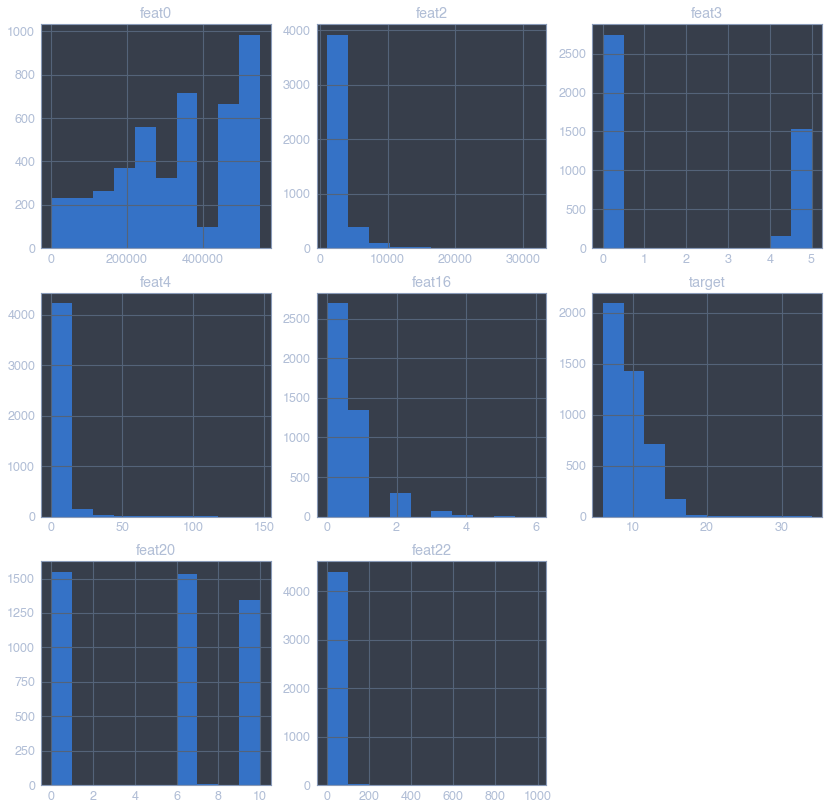

In [180]:
fig, ax = plt.subplots(3,3, figsize=(14,14))
ax = ax.flatten()
for i, feature in enumerate(data.select_dtypes(include=['int64', 'float64']).columns):
    ax[i].hist(x=data[feature])
    ax[i].set_title(feature)

ax[-1].axis('off')

plt.show()

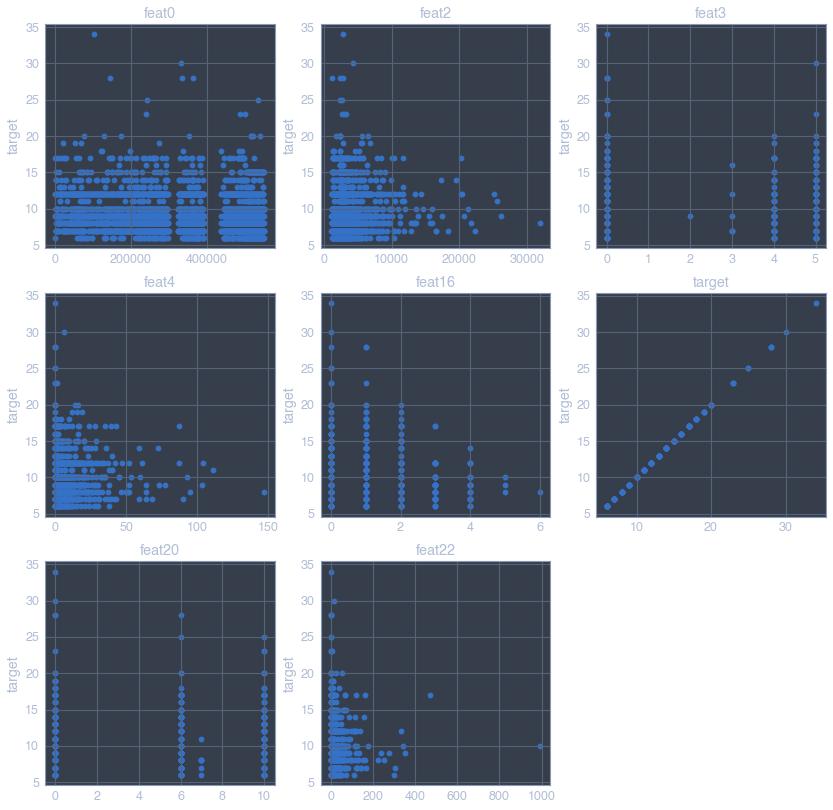

In [181]:
fig, ax = plt.subplots(3,3, figsize=(14,14))
ax = ax.flatten()
for i, feature in enumerate(data.select_dtypes(include=['int', 'float']).columns):
    ax[i].scatter(x=data[feature], y=data['target'])
    ax[i].set_title(feature)
    ax[i].set_ylabel('target')

ax[-1].axis('off')

plt.show()

It can be seen that there is hardly any positive or negative correlation between the numeric features and the target. In particular the feat0 columns do not show any correlation pattern, it is a feature with the sample identifier. I am going to remove it. The rest of the features do not correlate with the target but at least they show some pattern. I can also see that the target has some outliers that I will analyze later.

In [182]:
# Elimino columna id
data.drop('feat0', axis=1, inplace=True)

The correlation map helps to see how columns relate both positively and negatively to the target and to other columns. I can then determine which columns affect the target the most and which columns are related to each other and I can work with them to optimize the model.

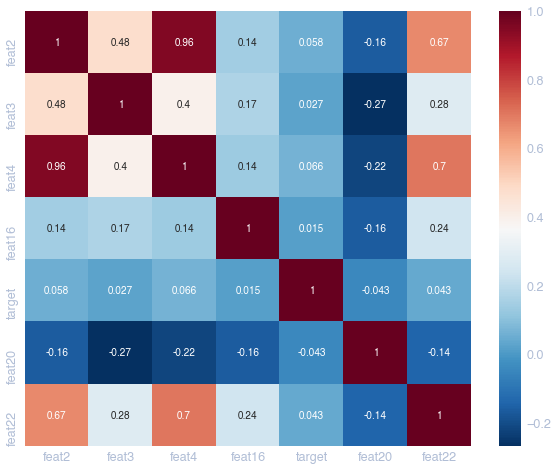

In [183]:
corrs = data.select_dtypes(include=['int', 'float']).corr()
plt.figure(figsize=(10,8))
sns.heatmap(corrs, cmap='RdBu_r', annot=True)
plt.show()

There is no column with a significant correlation with the target. Among the columns there is a strong positive correlation between feat2 and feat4. There is also a positive correlation between feat22 and feat2 and between feat22 and feat4. Let's show information from these columns.

In [184]:
high_corr = data[['feat2', 'feat4', 'feat22']]
print(high_corr)

      feat2  feat4  feat22
0      4725      9      26
1      5400     11       6
2      3580      4       3
3      3595      1       1
4     20620     77      53
...     ...    ...     ...
4908   3650      0       0
4909   4210      0       0
4910   3930      0       0
4911   2545      0       0
4912   4010      0       0

[4433 rows x 3 columns]


feat2 is a metric that encompasses the values of feat4 and feat22 among other variables. I will stick to the feat2 column only.

In [185]:
data.drop(['feat4', 'feat22'], axis=1, inplace=True)

## Non Numerical features EDA

All features are boolean except feat21 which is a dictionary. Let's unpack that dictionary and create a column for each key.

In [147]:
data['feat21'] = data['feat21'].apply(json.loads)
data = pd.concat([data, data['feat21'].apply(pd.Series)], axis=1)
data.drop(['feat21'], axis=1, inplace=True)

for i, name in enumerate(data.columns[-5:]):
    data.rename(columns={name: str('feat21_' + str(i))}, inplace=True)
    
non_numerical_describe = data.describe(exclude=['int64', 'float64']).drop('feat1', axis=1)
print(non_numerical_describe)

       feat5 feat6 feat7  feat8 feat9 feat10 feat11 feat12 feat13 feat14  \
count   4433  4433  4433   4433  4433   4433   4433   4433   2312   2312   
unique     2     2     2      2     2      2      2      2      1      2   
top     True  True  True  False  True   True   True   True  False  False   
freq    4123  3155  2660   2740  2395   3100   4073   3524   2312   2226   

       feat15 feat18 feat21_0 feat21_1 feat21_2 feat21_3 feat21_4  
count    2312   4433     4433     4433     4433     4433     4433  
unique      2      1        2        2        2        2        2  
top     False  False     True     True     True     True     True  
freq     2282   4433     3677     3928     4375     4006     3999  


It can be seen that features feat13, feat14 and feat15 have 2312 as opposed to 4433 in the rest of the features. Let's see how many null values there are in the non-numeric features.

In [148]:
data.select_dtypes(exclude=['int64', 'float64']).isnull().sum()

feat1          0
feat5          0
feat6          0
feat7          0
feat8          0
feat9          0
feat10         0
feat11         0
feat12         0
feat13      2121
feat14      2121
feat15      2121
feat18         0
feat21_0       0
feat21_1       0
feat21_2       0
feat21_3       0
feat21_4       0
dtype: int64

As there are 2121 null values in the those features I'll remove them.

In [149]:
data.drop(['feat13', 'feat14', 'feat15'], axis=1, inplace=True)
print(data.select_dtypes(exclude=['int64', 'float64']).isnull().sum())

feat1       0
feat5       0
feat6       0
feat7       0
feat8       0
feat9       0
feat10      0
feat11      0
feat12      0
feat18      0
feat21_0    0
feat21_1    0
feat21_2    0
feat21_3    0
feat21_4    0
dtype: int64


To see the percentage that occupies the majority value of each boolean feature, we create a new row in the describe(). In it we can see which features provide poor information by containing 80% or 90% of True or False values.

In [150]:
non_numerical_describe = data.describe(exclude=['int64', 'float64']).drop('feat1', axis=1)
non_numerical_describe.append(pd.Series(non_numerical_describe.loc['freq'] / non_numerical_describe.loc['count'], name='percentage'))

,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,feat18,feat21_0,feat21_1,feat21_2,feat21_3,feat21_4
count,4433,4433,4433,4433,4433,4433,4433,4433,4433,4433,4433,4433,4433,4433
unique,2,2,2,2,2,2,2,2,1,2,2,2,2,2
top,True,True,True,False,True,True,True,True,False,True,True,True,True,True
freq,4123,3155,2660,2740,2395,3100,4073,3524,4433,3677,3928,4375,4006,3999
percentage,0.93007,0.711708,0.600045,0.618092,0.540266,0.699301,0.918791,0.794947,1,0.829461,0.886082,0.986916,0.903677,0.902098


Almost all boolean features have a dominant value percentage (True or False) of more than 80%. It means that they hardly provide any information to predict the target. We have to look at the average value of the target divided between True and False for each boolean feature to determine whether it is worthwhile not to delete these features.

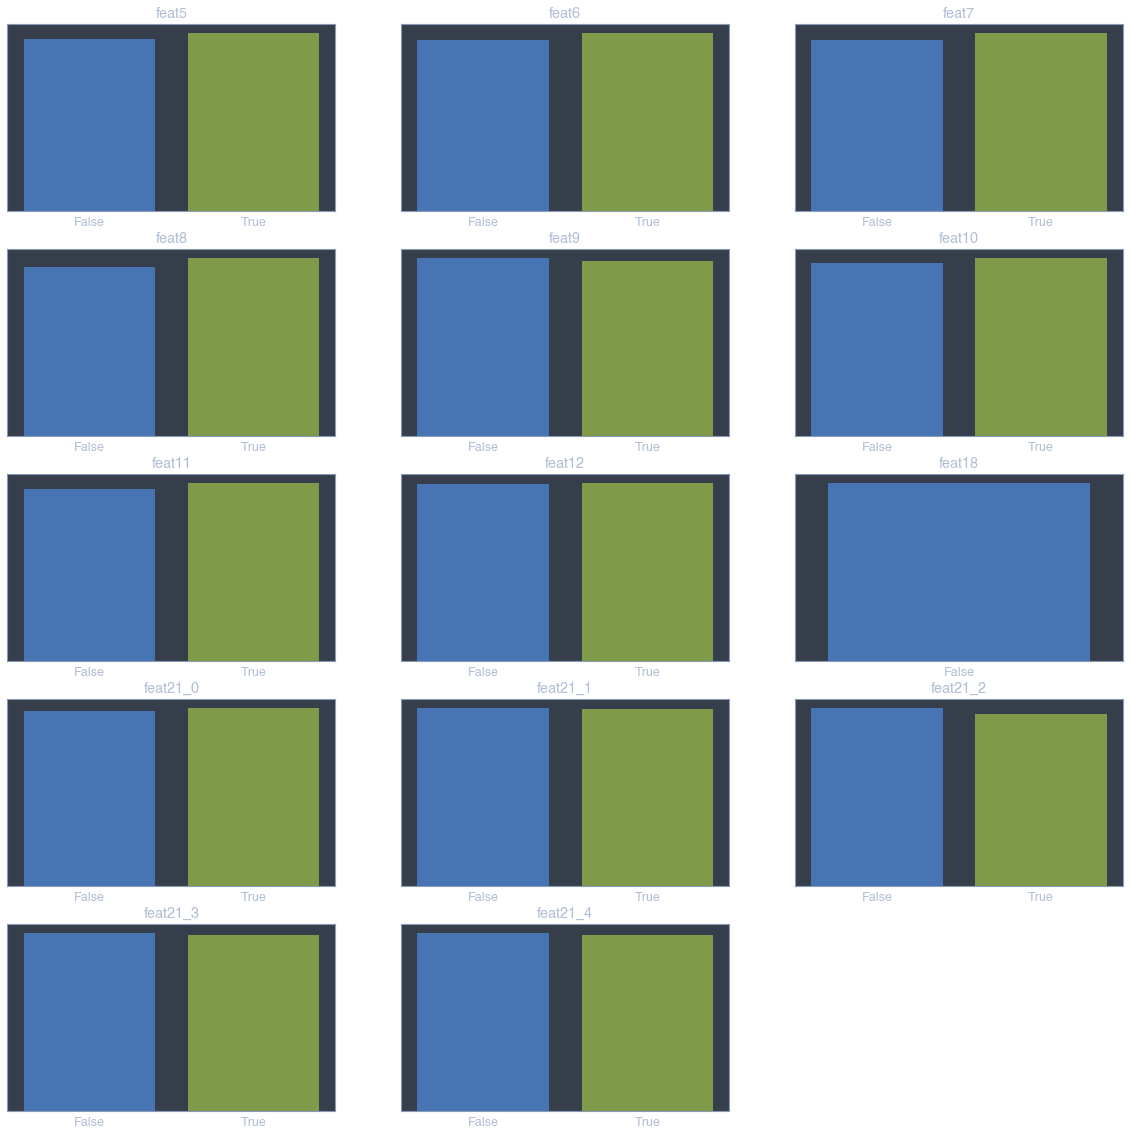

In [151]:
fig, axes = plt.subplots(5,3, figsize=(20,20))

axes = axes.flatten()

for i, column in enumerate(data.select_dtypes('bool')):
    sns.barplot(ax=axes[i],x=data.groupby(column)['target'].mean().index,
                y=data.groupby(column)['target'].mean().values)
    
    axes[i].set_xticks(data.groupby(column)['target'].mean().index)
    axes[i].set_title(label = column, loc='center')
    axes[i].set_xlabel('')
    axes[i].yaxis.set_visible(False)
    
axes[-1].axis('off')

plt.tight_layout

plt.show()

I see that the mean of the target for the examples with True and False values is practically the same. This means that in features that have a 10% minority category (True or False), that 10% does not help to better predict the target.

I'll remove features feat18 because it contains all False.

In [152]:
data.drop('feat18', axis=1, inplace=True)

## Target EDA

I will analyze the possible outliers contained in the target.

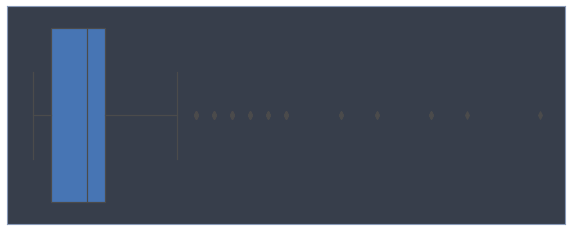

In [153]:
fig, ax = plt.subplots(figsize=(10,4))

sns.boxplot(data=data['target'], orient='h')
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)

plt.show()

There are quite a few ouliers. I am going to remove those rows with outliers to improve the prediction. To do this I will create a function to calculate the quartiles Q1, Q2, Q3, and the IQR to find the outliers below the minimum and maximum.

In [154]:
def outliers(dataset, column):
    Q1 = np.percentile(dataset[column], 25)
    Q2 = np.percentile(dataset[column], 50)
    Q3 = np.percentile(dataset[column], 75)

    IQR = Q3 - Q1
    
    Min = Q1 - 1.5 * IQR
    Max = Q3 + 1.5 * IQR

    outliers = []
    for value in dataset[column]:
        if value < Min or value > Max:
            outliers.append(value)
    print('Total Outliers Removed',len(outliers))

    return outliers


outliers_price = list(outliers(data, 'target'))

for out in outliers_price:
    data.drop(data[data['target'] == out].index, inplace=True)

Total Outliers Removed 199


## A little preprocessing

The algorithm we use to predict the target must be given the data in such a way that it can interprest it well.

For this I am going to do a one hot encoding to the features feat1 and feat3. feat1 is a column string and feat3 is a rank. In both cases we will create a new feautures for each unique value. New dataset shape will have 73 features.

In [155]:
# feat1 feature enginnering
data['feat1'] = data['feat1'].str[:2]

# get_dummies a feat1 y feat3
data[['feat1', 'feat3']] = data[['feat1', 'feat3']].astype('str')
data = pd.get_dummies(data)

print('Shape after one hot',data.shape)

Shape after one hot (4234, 73)


I will modify the boolean columns by converting the values True and False to 1 and 0 with a label encoder.

In [156]:
# Label encoding features booleanas
for column in data:
    if data[column].dtype == 'bool':
        data[column].replace([True, False], [1, 0], inplace=True)

To give the algorithm that we use the standardized values, we will scale the values of all the columns except the target, between 0 and 1. The difference in scale between the features is worsens the learning and prediction of the model.

In [157]:
scaler = MinMaxScaler()
data.loc[:, data.columns != 'target'] = scaler.fit_transform(data.loc[:, data.columns != 'target'])

data.head()

,feat2,feat5,feat6,feat7,feat8,feat9,feat10,feat11,feat12,feat16,...,feat1_47,feat1_48,feat1_49,feat1_50,feat1_52,feat3_0,feat3_2,feat3_3,feat3_4,feat3_5
0,0.120360,1.0,1.0,1.0,1.0,0.0,0.0,1.0,1.0,0.333333,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,0.142205,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,0.083304,1.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.166667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.083789,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,0.634778,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,0.166667,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


## Random Forest

In the exploratory analysis of the data I have seen that the model is not linear, so I will have to use a prediction algorithm other than Linear Regression such as Random Forest.

First I will divide the dataset between the features that we are going to use to learn and predict the target (X) and the target variable (y).

In [158]:
X = data.loc[:, data.columns != 'target'].values
y = data['target'].values

To get a good prediction it's necessary to properly prepare the dataset to give to the algorithm and tune the parameters of the learning algorithm to avoid underfitting and overfitting. Ensemble learning algorithms tend to create overfitting, which means that they overtrain and are not able to generalize to predict new data.

To find the optimal parameters I will use GridSearchCV from the sklearn library, which allows to obtain the best combination of algorithm parameters to get the best score.

In [165]:
# GridSearchCV
params = {'n_estimators': [50,100,150,200,250,300],
          'max_depth': [int(x) for x in np.linspace(0,100,11)],
          'max_features': ['auto', 'sqrt', 'log2']
          }

grid = GridSearchCV(estimator=RandomForestRegressor(random_state=0),
                    param_grid=params,
                    cv=3,
                    n_jobs=-1,
                    verbose=3)

grid_results = grid.fit(X,y)
print('Best {} using {}'.format(grid_results.best_score_, grid_results.best_params_))

Fitting 3 folds for each of 198 candidates, totalling 594 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done 120 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 504 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 594 out of 594 | elapsed:  5.9min finished


Best 0.024617416081331278 using {'max_depth': 10, 'max_features': 'sqrt', 'n_estimators': 250}


Once I know the best parameters for our model I proceed to generate again the Random Forest predictor but with the best parameters. I will also use 3 kfolds to check if the prediction is robust or not.

Due to the type of data I want to predict I am interested in creating a custom score metric. For this we create the function custom_score whose output will be "hit" or "miss" if the difference between the actual target value and the predicted one is greater than 3.

In [166]:
cv = KFold(n_splits=3, random_state=0, shuffle=True)
rf = RandomForestRegressor(max_depth= 10,
                           max_features= 'sqrt',
                           n_estimators= 250,
                           n_jobs= -1
                           )

# Score function
def custom_score (true, pred):
    result = list()
    for true, pred in zip(true, pred):
        if abs(true - pred) <= 3:
            result.append('sucess')
        else:
            result.append('failure')

    result = pd.Series(result)

    return result

## Evaluation

Finally I train the model using 3 kfolds, and generate a prediction for each kfold. The resulting output will be the custom score, which is the percetage of correct predictions for both the train (the part of the dataset with which we have trained the model) and the test (the part of the dataset with which we have not trained the model).

In [168]:
# Predicción y score
test_score = list()
train_score = list()

for train_index, test_index in cv.split(X):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    rf.fit(X_train, y_train)

    test_pred = np.round(rf.predict(X_test)).astype(int)
    test_custom_score = custom_score(y_test, test_pred)
    try:
        test_custom_score = test_custom_score.value_counts()[0] / (test_custom_score.value_counts()[1] + test_custom_score.value_counts()[0])
    except IndexError:
        test_custom_score = float(100)

    test_score.append(test_custom_score)


    train_pred = np.round(rf.predict(X_train)).astype(int)
    train_custom_score = custom_score(y_train, train_pred)
    try:
        train_custom_score = train_custom_score.value_counts()[0] / (train_custom_score.value_counts()[1] + train_custom_score.value_counts()[0])
    except IndexError:
        train_custom_score = float(100)

    train_score.append(train_custom_score)
    

test_score = np.asarray(test_score)
train_score = np.asarray(train_score)

score = pd.DataFrame({'Train': train_score, 'Test': test_score})

score

TRAIN: [   0    3    6 ... 4228 4231 4232] TEST: [   1    2    4 ... 4229 4230 4233]
TRAIN: [   0    1    2 ... 4231 4232 4233] TEST: [   6    8   11 ... 4225 4226 4228]
TRAIN: [   1    2    4 ... 4229 4230 4233] TEST: [   0    3    7 ... 4223 4231 4232]


,Train,Test
0,0.980510,0.960340
1,0.977683,0.968816
2,0.975204,0.965982


Thank you for your attention. More projects coming soon!